In [30]:
import pandas as pd
import numpy as np
import phunk
from sbpy import photometry as phot
import numpy as np
import lmfit
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

#from matplotlib.widgets import Button

#%matplotlib widget
%matplotlib inline

In [31]:
def read_excel(path, excel_file, sheet_name = "T08o"):
    # Read the specified sheet into a DataFrame
    df = pd.read_excel(path + excel_file, sheet_name=sheet_name)
    df.sort_values('Ph')
    df['magred'] = pd.to_numeric(df['magred'], errors='coerce')  # Convert to numeric, NaN for invalid values
    df['Ph'] = pd.to_numeric(df['Ph'], errors='coerce')          # Convert to numeric, NaN for invalid values
    df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce')

    
    # Extract the columns and convert them to NumPy arrays
    real_mag = np.array(df['magred']) + 0.4  # Correction from the Red filter
    real_mag = real_mag - 0.08 # Korekcija observatorijai
    ph = df['Ph'].to_numpy(dtype = np.float64)
    epoch = df['epoch'].to_numpy(dtype = float)
    band = ["R"]*len(epoch)
    return real_mag, ph, epoch, band

In [32]:
def outlier_remover(df):
    epochs = np.array([int(x) for x in df[2]])
    epochs_set = list(set(epochs))
    remove_idx = []
    for epoch in epochs_set:
        idx = np.where(epochs == epoch)
        temp_ep_list = np.array(df[0][idx], dtype = np.float64)
        z = np.abs(stats.zscore(temp_ep_list))

        threshold_z = 2

        outlier_indices = np.where(z > threshold_z)
        # Back to original
        outlier_indices = idx[0][np.array(outlier_indices)]

        if outlier_indices != None:
            remove_idx.append(outlier_indices)
    print (remove_idx)
    remove_idx = np.array(remove_idx).flatten()
    
    plt.scatter(df[1], df[0], color = "blue", alpha  = 0.6)
    plt.scatter(df[1][remove_idx], df[0][remove_idx], c = "orange", alpha = 0.8, label = "sigma removed", marker = "x")
    
    df = np.delete(df, remove_idx, axis = 1)
    
    return df
        #print (outlier_indices)

In [33]:
def outlier_remover_total(df, contamination = 0.01, n_estimators = 200):
    real_mag, ph, epoch, band = df
    
    X = np.column_stack((ph, real_mag, epoch))

    scaler = StandardScaler()

    # Create an Isolation Forest model
    iso_forest = IsolationForest(max_samples="auto", random_state=0,contamination=contamination, n_estimators = n_estimators) # Adjust contamination based on your dataset
    # Fit the model to your data
    X = np.column_stack((ph, real_mag, epoch))

    X_scaled = scaler.fit_transform(X)

    iso_forest.fit(X_scaled)
    # Predict outliers
    outliers = iso_forest.predict(X_scaled)  == -1 
    # Keep the ones with the phase below 5, as it usually discards them due to non-linear behaviour
    idx_keep = np.where(ph <= 5)[0]
    outliers[idx_keep] = False
    
    plt.scatter(X[:,0], X[:,1], label = "data", color = "blue", alpha = 0.6)
    plt.scatter(X[:,0][outliers], X[:,1][outliers], c = "red", alpha = 0.8, label = "group removed", marker = "x")
    plt.xlabel("Phase")
    plt.ylabel("Reduced mag")
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()
    return real_mag[~outliers], ph[~outliers], epoch[~outliers]

In [34]:
def eval_fit_HG(phase, H, G):
    """Evaluation function for fitting. Required for lmfit."""
    return phot.HG.evaluate(np.radians(phase), H, G)
def eval_fit_HG1G2(phase, H, G1, G2):
    """Evaluation function for fitting. Required for lmfit."""
    return phot.HG1G2.evaluate(np.radians(phase), H, G1, G2)

import lmfit
import numpy as np

def fit(phase, mag, weights=None, method="HG", mag_errors=None):
    """
    Fit a phase curve using the HG or HG1G2 model with constraints.

    Parameters:
    - phase (array-like): Phase angles.
    - mag (array-like): Observed magnitudes.
    - weights (array-like, optional): Weights for fitting. Defaults to 1/mag_errors.
    - method (str): Phase function model to use ("HG" or "HG1G2").
    - mag_errors (array-like, optional): Magnitude uncertainties. Defaults to 0.03 for all data points.

    Returns:
    - result: Fitting result object from lmfit.
    """
    # Select the appropriate model
    if method == "HG":
        model = lmfit.Model(eval_fit_HG)
    elif method == "HG1G2":
        model = lmfit.Model(eval_fit_HG1G2)
    else:
        raise ValueError("Invalid method. Use 'HG' or 'HG1G2'.")

    # Initialize parameters
    params = lmfit.Parameters()
    params.add("H", value=15, min=0, max=30)

    if method == "HG":
        params.add("G", value=0.15, min=0, max=1.0)
    elif method == "HG1G2":
        params.add("G1", value=0.15, min=0, max=1.0)  # Free parameter
        params.add("G2", value = 0.2, min=0, max = 1.0)        # Dependent parameter ensuring G1 + G2 <= 1

    # Set default magnitude errors if not provided
    if mag_errors is None:
        mag_errors = np.full(len(phase), 0.03)

    # Default weights if not provided
    if weights is None:
        weights = 1.0 / mag_errors

    # Perform the fit
    result = model.fit(
        mag,
        params,
        phase=phase,
        method="least_squares",
        weights=weights,
        fit_kws={"loss": "soft_l1"},
    )

    return result


In [35]:
def hg_phase_function(H, G, alpha):
    """
    Calculate the apparent magnitude V of an asteroid at phase angle alpha
    using the HG phase function.

    Parameters:
    - H (float): Absolute magnitude of the asteroid.
    - G (float): Slope parameter of the asteroid (0 ≤ G ≤ 1).
    - alpha (float or array-like): Phase angle(s) in degrees.

    Returns:
    - V (float or array-like): Apparent magnitude(s) at phase angle(s) alpha.
    """
    # Convert alpha to radians
    alpha_rad = np.radians(alpha)

    # Compute Phi1 and Phi2
    phi1 = np.exp(-3.33 * np.power(np.tan(alpha_rad / 2), 0.63))
    phi2 = np.exp(-1.87 * np.power(np.tan(alpha_rad / 2), 1.22))

    # Compute the magnitude V(alpha)
    V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)

    return V

In [36]:
def hg1g2_phase_function(alpha, H, G1, G2):
    """
    Calculate the apparent magnitude V of an asteroid at phase angle alpha
    using the HG1G2 phase function.

    Parameters:
    - H (float): Absolute magnitude of the asteroid.
    - G1 (float): Slope parameter 1 of the asteroid (0 ≤ G1 ≤ 1).
    - G2 (float): Slope parameter 2 of the asteroid (0 ≤ G2 ≤ 1).
    - alpha (float or array-like): Phase angle(s) in degrees.

    Returns:
    - V (float or array-like): Apparent magnitude(s) at phase angle(s) alpha.
    """
    # Convert alpha to radians
    alpha_rad = np.radians(alpha)
    
    file_path = r"C:\Users\nagai\Downloads\phases_and_phi.txt"
    cs_ph1, cs_ph2, cs_ph3 = spline(file_path)
    # Compute Phi1 and Phi2
    phi1 = cs_ph1(alpha)
    phi2 = cs_ph2(alpha)

    # Compute Phi3 using alpha in degrees
    phi3 = cs_ph3(alpha)

    # Compute the magnitude V(alpha) using the HG1G2 function
    V = H - 2.5 * np.log10(G1 * phi1 + G2 * phi2 + (1 - G1 - G2) * phi3)

    return V


In [37]:
def spline(file_path):
    delimiter = None
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize an empty list to store columns
    columns = []

    for line in lines:
        # Split the line by the delimiter
        values = line.strip().split(delimiter)

        # Append values to corresponding column lists
        if not columns:
            columns = [[] for _ in values]  # Initialize columns on the first row

        for i, value in enumerate(values):
            columns[i].append(float(value))
    ph = np.array(columns[0] + columns[4] + columns[8])
    phi1 = np.array(columns[1] + columns[5] + columns[9])
    phi2 = np.array(columns[2] + columns[6] + columns[10])
    phi3 = np.array(columns[3] + columns[7] + columns[11])
    
    idx = np.where(ph == 8)
    
    ph = np.delete(ph, idx[0])
    phi1 = np.delete(phi1, idx[0])
    phi2 = np.delete(phi2, idx[0])
    phi3 = np.delete(phi3, idx[0])
    
    return CubicSpline(ph, phi1), CubicSpline(ph, phi2), CubicSpline(ph, phi3)

In [52]:
def phunk_graph(ph, real_mag, epoch, target):
    pc = phunk.PhaseCurve(phase=ph, mag=real_mag, epoch = epoch - 2400000.5, target=target)

    pc.fit(["HG", "HG1G2", "HG12S", "sHG1G2"])
    if save_fig:
        pc.plot(save=save_path + asteroid_numb + "phunk_graph.jpg")
    else:
        pc.plot()
    plt.show()

In [39]:
def mag_area_HG(results, H_val, G_val, ph_an):
        
    # Get the covariance matrix
    cov_matrix = results.covar  # result.covar is the covariance matrix
    
    # Construct covariance matrix for multivariate normal sampling
    params_mean = np.array([H_val, G_val])
    
    # Just to make consistent the following code
    params_cov = cov_matrix
    # 8. Generate sample parameters from multivariate normal distribution
    n_samples = 3000  # Number of simulations
    samples = np.random.multivariate_normal(params_mean, params_cov, n_samples)

    # 9. Compute model magnitudes for each set of sampled parameters
    mag_samples = np.zeros((n_samples, len(ph_an)))

    for i in range(n_samples):
        H_sample, G_sample = samples[i]
        mag_samples[i] = hg_phase_function(H_sample, G_sample, ph_an)
    return mag_samples

In [40]:
def mag_area_HG1G2(results, H_val_2, G1_val, G2_val, ph_an):
    """
    Generate sampled magnitudes for the HG1G2 model considering parameter uncertainties.

    Parameters:
    - results: Fitting result object containing the covariance matrix.
    - H_val_2 (float): Best-fit absolute magnitude H.
    - G1_val (float): Best-fit slope parameter G1.
    - G2_val (float): Best-fit slope parameter G2.
    - ph_an (array-like): Phase angles in degrees.

    Returns:
    - mag_samples (ndarray): Simulated magnitudes for parameter samples and phase angles.
    """

    # Get the covariance matrix
    cov_matrix = results.covar  # Ensure this is a 3x3 matrix for [H, G1, G2]
    
    # Construct mean parameter vector
    params_mean = np.array([H_val_2, G1_val, G2_val])
    print(cov_matrix)
    # Ensure covariance matrix shape matches parameters
    if cov_matrix.shape != (3, 3):
        raise ValueError("Covariance matrix must be 3x3 for parameters [H, G1, G2]")

    # Generate sample parameters from multivariate normal distribution
    n_samples = 3000  # Number of simulations
    samples = np.random.multivariate_normal(params_mean, cov_matrix, n_samples)

    # Initialize array to store sampled magnitudes
    mag_samples = np.zeros((n_samples, len(ph_an)))

    # Loop through samples and compute model magnitudes
    for i in range(n_samples):
        H_sample, G1_sample, G2_sample = samples[i]

        # Apply constraints to G1 and G2
        if G1_sample < 0 or G2_sample < 0 or (G1_sample + G2_sample > 1):
            continue  # Skip invalid parameter samples

        # Compute magnitudes using the HG1G2 phase function
        mag_samples[i] = hg1g2_phase_function(ph_an, H_sample, G1_sample, G2_sample)
    # Step 1: Identify rows that are not all zeros
    non_zero_rows = ~np.all(mag_samples == 0, axis=1)

    # Step 2: Filter out rows with all zeros
    filtered_data = mag_samples[non_zero_rows]
    return filtered_data


In [56]:
def comp_plot(ph, real_mag, H_MPC, HG1G2 = True):
    # HG results
    results1 = fit(ph, real_mag, method="HG")

    H_val = results1.params["H"].value
    G_val = results1.params["G"].value

    H_err = results1.params["H"].stderr or 0
    G_err = results1.params["G"].stderr or 0

    ph_an = np.linspace(0, max(ph) + 2, 100)
    mag_analy = hg_phase_function(H_val, G_val, ph_an)

    mag_MPC = hg_phase_function(H_MPC, 0.15, ph_an)

    mag_samples = mag_area_HG(results1, H_val, G_val, ph_an)

    # Compute percentiles at each phase angle
    mag_percentiles = np.percentile(mag_samples, [16, 84], axis=0)

    plt.scatter(ph, real_mag, s=7, c="black", marker="o", label="Data")
    plt.plot(ph_an, mag_analy, c="red", label=r"HG : H= {:.2f} $\pm$ {:.2f}, G = {:.2f} $\pm$ {:.2f}".format(H_val, H_err, G_val, G_err))
    
    if HG1G2:
        results2 = fit(ph, real_mag, method="HG1G2")

        H_val_2 = results2.params["H"].value
        G1_val = results2.params["G1"].value
        G2_val = results2.params["G2"].value

        H_err_2 = results2.params["H"].stderr or 0
        G1_err = results2.params["G1"].stderr or 0
        G2_err = results2.params["G2"].stderr or 0
        
        mag_analy_2 = hg1g2_phase_function(ph_an, H_val_2, G1_val, G2_val)
        
        mag_samples_2 = mag_area_HG1G2(results2, H_val_2, G1_val, G2_val, ph_an)
        
        mag_percentiles_2 = np.percentile(mag_samples_2, [16, 84], axis=0)
        
        plt.plot(ph_an, mag_analy_2, c="orange", label=r"HG1G2: H= {:.2f} $\pm$ {:.2f}, G1 = {:.2f} $\pm$ {:.2f}, G2 = {:.2f} $\pm$ {:.2f}".format(H_val_2, H_err_2, G1_val, G1_err, G2_val, G2_err))
        plt.fill_between(ph_an, mag_percentiles_2[0], mag_percentiles_2[1], color="orange", alpha=0.3, label="HG1G2 1-sigma uncertainty")
        
        print ("Average displacement HG1G2: ", np.median(mag_analy_2 - mag_MPC))
        
    plt.plot(ph_an, mag_MPC, c="blue", label="MPC: H= {}, G= 0.15".format(H_MPC))

    plt.fill_between(ph_an, mag_percentiles[0], mag_percentiles[1], color="red", alpha=0.3, label="HG 1-sigma uncertainty")

    plt.legend()
    plt.xlim(0, max(ph) + 2)
    plt.ylim(min(real_mag) - 1, max(real_mag) + 1)
    plt.xlabel("Phase (degrees)")
    plt.ylabel("Reduced V")
    ax = plt.gca()
    ax.invert_yaxis()
    if save_fig:
        plt.savefig(save_path + asteroid_numb + "error_region")
    plt.show()
    
    print ("Average displacement HG: ", np.median(mag_analy - mag_MPC))

In [42]:
def interactive_data_removal(x, y, z):
    """
    Interactive scatter plot with a stop button to remove points in Jupyter Notebook.

    Parameters:
        x, y, z (list or array-like): Coordinates and associated data.
    
    Returns:
        Updated x, y, z arrays after points have been removed.
    """
    # Convert inputs to numpy arrays for easier indexing
    x, y, z = map(np.array, (x, y, z))
    is_active = True  # Flag to control interactivity

    # Create the figure and scatter plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(y, x, picker=True)  # Enable picking
    ax.set_title("Click on a point to remove it. Click 'Stop' to finish.")
    ax.invert_yaxis()

    # Add a "Stop" button
    stop_ax = plt.axes([0.8, 0.02, 0.1, 0.04])  # Position: [left, bottom, width, height]
    stop_button = Button(stop_ax, 'Stop')

    # Event handler to stop the interaction
    def stop_interaction(event):
        nonlocal is_active
        is_active = False
        print ("Is_active variable: ", is_active)
        fig.canvas.mpl_disconnect(cid_pick)  # Disconnect the pick event
        plt.close(fig)  # Close the plot when "Stop" is clicked

    # Attach the stop button event
    stop_button.on_clicked(stop_interaction)

    # Event handler for clicking on points
    def on_pick(event):
        if not is_active:
            return
        ind = event.ind[0]  # Get index of the clicked point
        nonlocal x, y, z
        x, y, z = np.delete(x, ind), np.delete(y, ind), np.delete(z, ind)
        scatter.set_offsets(np.c_[y, x])  # Update scatter plot
        fig.canvas.draw_idle()  # Redraw the canvas

    # Connect the pick event to the handler
    cd_int = fig.canvas.mpl_connect('pick_event', on_pick)

    # Show the plot and explicitly block further execution
    plt.show(block=True)

    # Return the updated datasets
    return x, y, z


In [43]:
def main(path, excel_file, target_name, H_MPC, outlier_removing = True, HG1G2 = True,
         total_outlier_removing = True, contamination = 0.01, sheet_name = "T08o",
        interactive = False):
    # read in files
    real_mag, ph, epoch, band = read_excel(path, excel_file, sheet_name = sheet_name)
    
    if outlier_removing:
        real_mag, ph, epoch, band = outlier_remover([real_mag, ph, epoch, band])

        real_mag = np.array(real_mag, dtype = np.float64)
        ph = np.array(ph, dtype = np.float64)
        epoch = np.array(epoch, dtype = np.float64)
    if total_outlier_removing:
        real_mag, ph, epoch = outlier_remover_total([real_mag, ph, epoch, band], contamination = contamination)
        
    if interactive:
        real_mag, ph, epoch = interactive_data_removal(real_mag, ph, epoch)
        #x = input("If you are finished, write 'Done:'")
        #if input == "Done":
        #    pass
    # get the plot
    phunk_graph(ph, real_mag, epoch, target_name)
    # Compare plots with MPC results
    comp_plot(ph, real_mag, H_MPC, HG1G2 = HG1G2)

# 1951 Lick

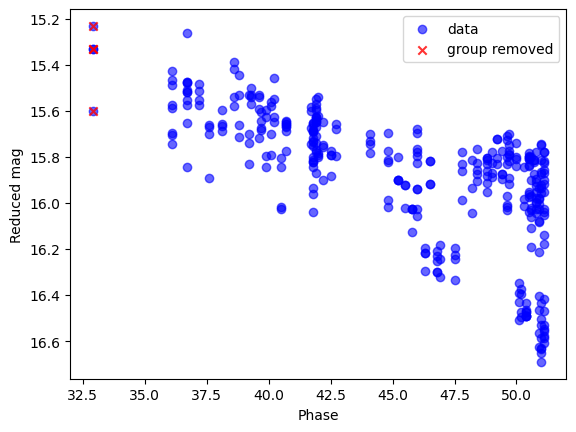

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


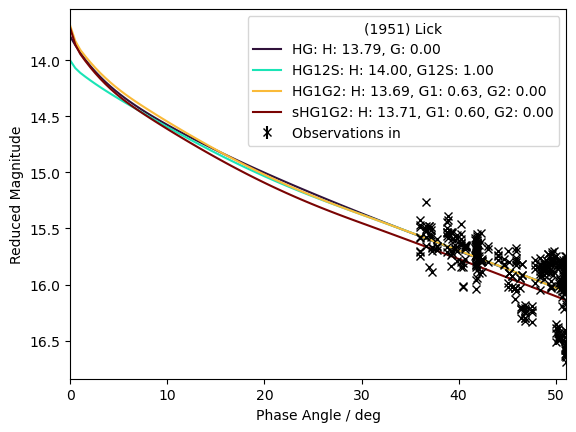

C:\Users\nagai\AppData\Local\Temp\ipykernel_40460\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


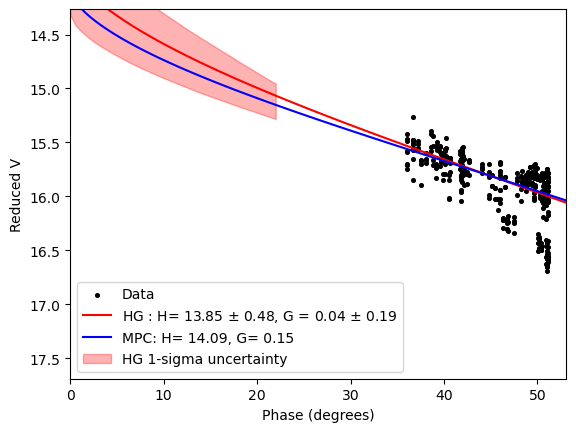

Average displacement HG:  -0.06519111516717935


In [57]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '1951-excelB.xlsx'

save_fig = False
save_path = r"C:\Users\nagai\Documents\Asteroid work\\"

asteroid_numb = "1951"


main(path, excel_file, asteroid_numb, 14.09, outlier_removing= False, HG1G2=False, interactive = False)

# 2607


C:\Users\nagai\AppData\Local\Temp\ipykernel_40460\1193743473.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if outlier_indices != None:


[array([[233]], dtype=int64), array([[35]], dtype=int64)]


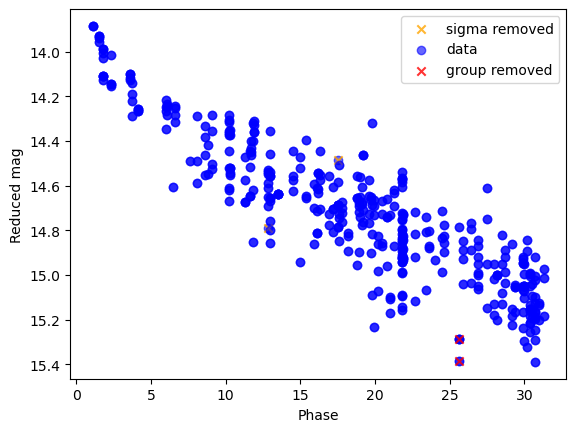

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


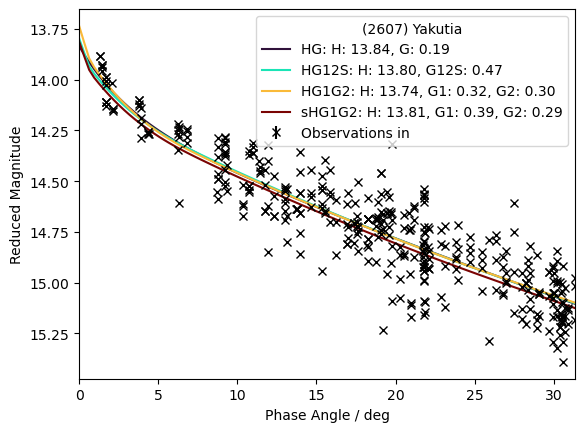

[[ 0.02266528  0.02693253 -0.00518815]
 [ 0.02693253  0.04267992 -0.01250537]
 [-0.00518815 -0.01250537  0.0050154 ]]
Average displacement HG1G2:  0.0007469032106319773


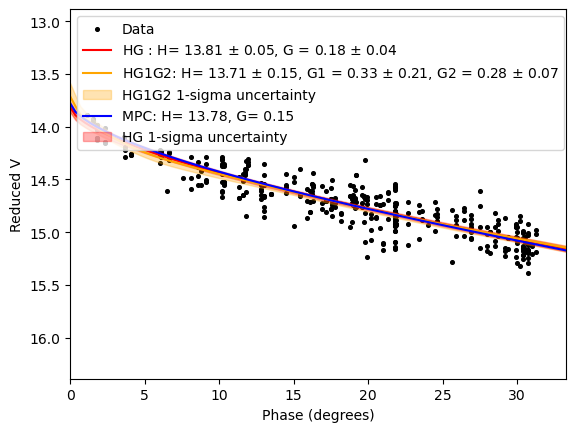

Average displacement HG:  0.00022112881324964917


In [22]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '2607-excelB.xlsx'

main(path, excel_file, "2607", 13.78, contamination = 0.01, interactive = False)

# 2680

C:\Users\nagai\AppData\Local\Temp\ipykernel_3440\1193743473.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if outlier_indices != None:


[array([[33]], dtype=int64), array([[78]], dtype=int64), array([[99]], dtype=int64)]


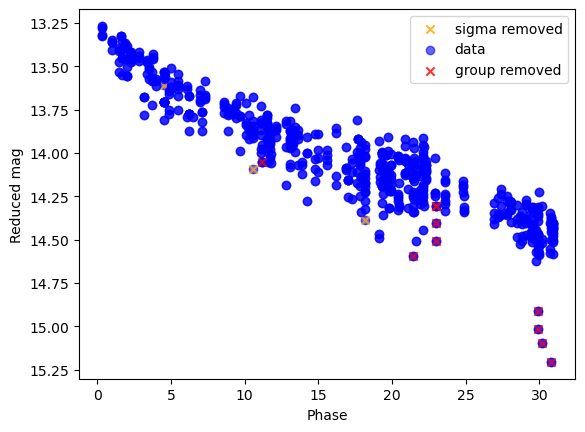

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


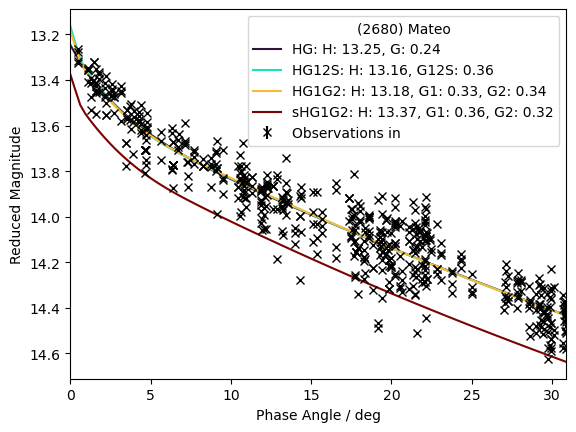

[[ 0.00328125  0.00426092 -0.00079406]
 [ 0.00426092  0.00822372 -0.00269729]
 [-0.00079406 -0.00269729  0.00125019]]
Average displacement HG1G2:  -0.006475803131475999


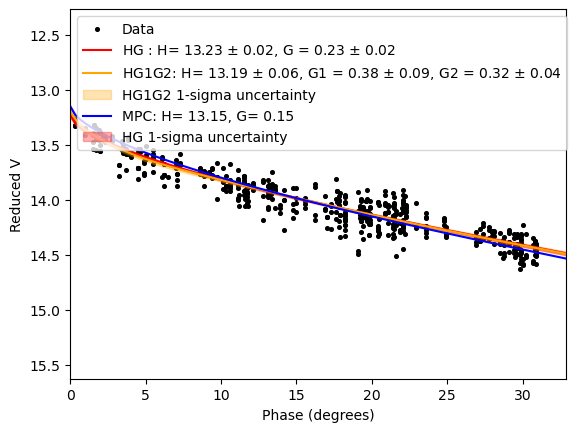

Average displacement HG:  -0.005217455731903797


In [31]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '2680-excelB.xlsx'

main(path, excel_file, "2680", 13.15, contamination = 0.04)

# 2817

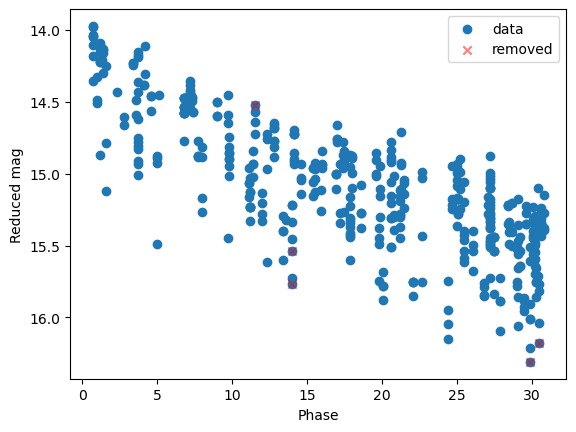

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


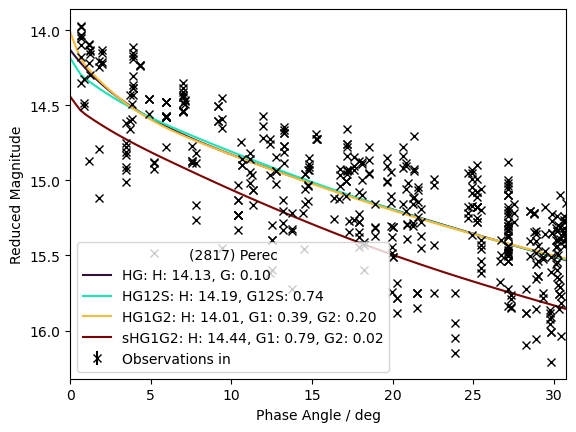

[[ 0.07530452  0.11318055 -0.03482375]
 [ 0.11318055  0.24393463 -0.09608383]
 [-0.03482375 -0.09608383  0.04249931]]
Average displacement HG1G2:  0.036727154956278873


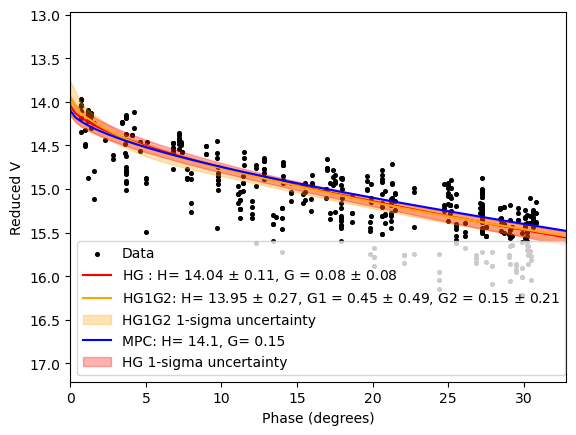

Average displacement HG:  0.02976194020048961


In [138]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '2817-excelB.xlsx'

main(path, excel_file, "2817", 14.1, outlier_removing=False)

# 2899

C:\Users\nagai\AppData\Local\Temp\ipykernel_21920\3424124797.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if outlier_indices != None:


[array([[319]], dtype=int64), array([[261]], dtype=int64)]


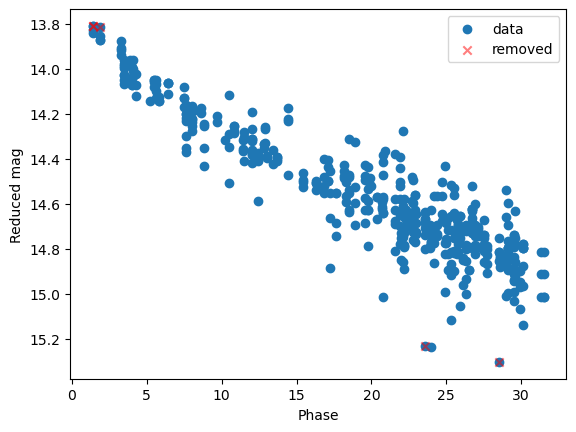

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


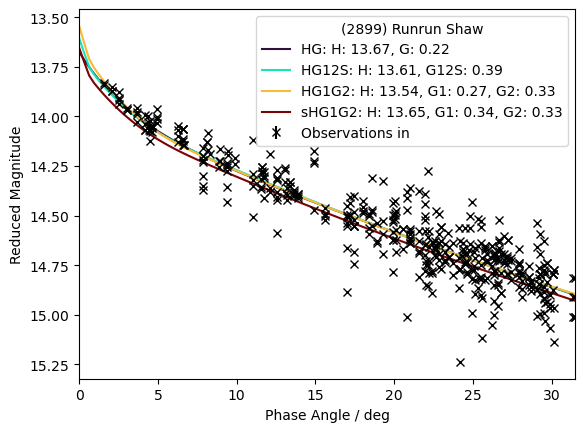

[[ 0.01477766  0.01569392 -0.00200247]
 [ 0.01569392  0.02004157 -0.00416426]
 [-0.00200247 -0.00416426  0.00152816]]
Average displacement HG1G2:  -0.0003042481976249789


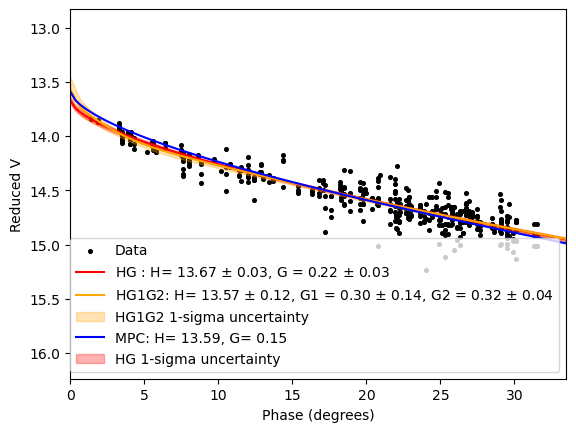

Average displacement HG:  0.001180429899876323


In [139]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '2899-excelB.xlsx'

main(path, excel_file, "2899", 13.59)

# 3098

C:\Users\nagai\AppData\Local\Temp\ipykernel_27652\3424124797.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if outlier_indices != None:


[array([[78]], dtype=int64)]


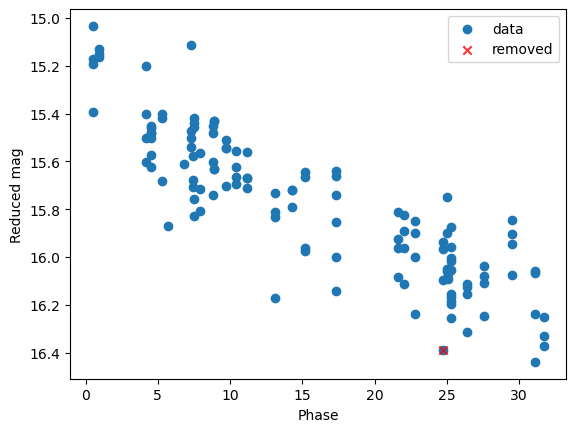

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


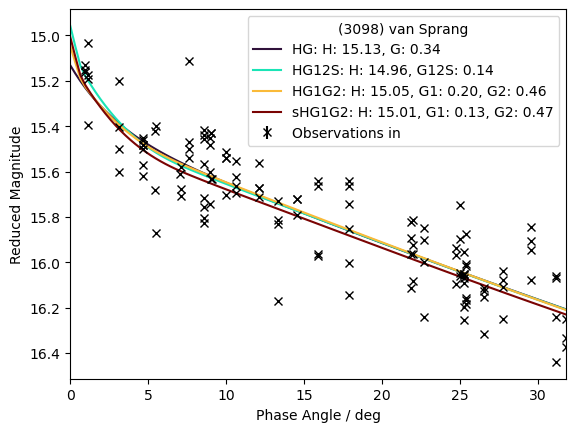

[[ 0.04714117  0.04373854 -0.00011921]
 [ 0.04373854  0.06581228 -0.01610066]
 [-0.00011921 -0.01610066  0.01040083]]
Average displacement HG1G2:  -0.01779077382987193


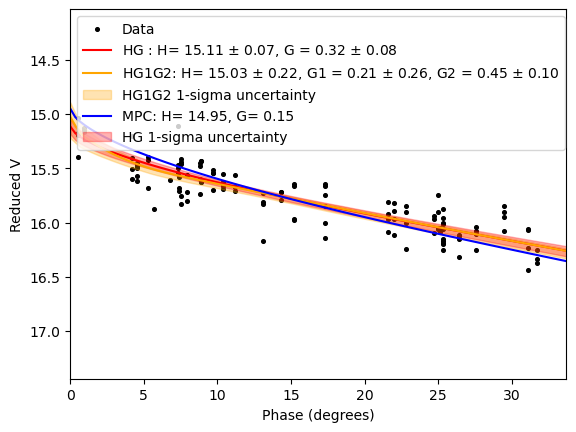

Average displacement HG:  -0.015158236444063888


In [30]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '3098-excelB.xlsx'

main(path, excel_file, "3098", 14.95, contamination = 0.02)

# 1740

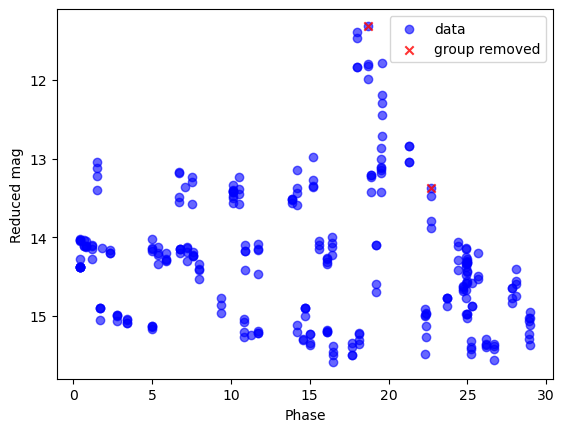

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


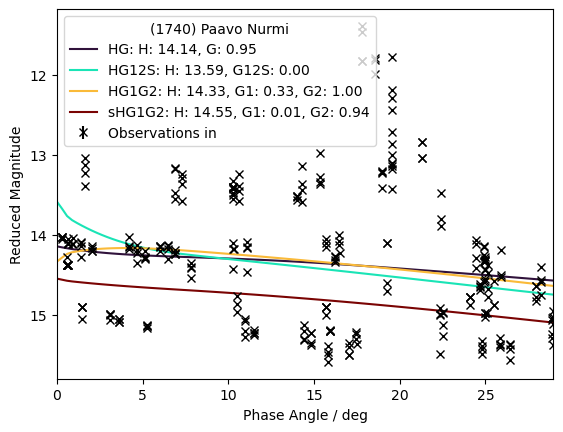

C:\Users\nagai\AppData\Local\Temp\ipykernel_40460\4132042645.py:22: RuntimeWarning: invalid value encountered in log10
  V = H - 2.5 * np.log10((1 - G) * phi1 + G * phi2)


[[ 2.7450354   3.81536662  0.65784313]
 [ 3.81536662  8.59905366 -1.32668909]
 [ 0.65784313 -1.32668909  1.74523354]]
Average displacement HG1G2:  0.13700249218699767


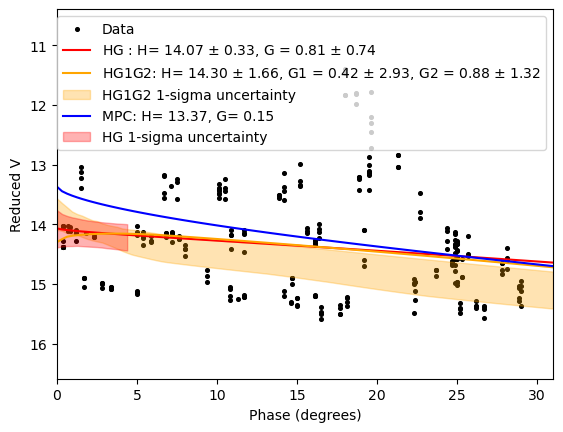

Average displacement HG:  0.14381222936900429


In [27]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '1740-excelBF.xlsx'

main(path, excel_file, "1740", 13.37, outlier_removing= False, HG1G2=True, interactive = False, sheet_name = "T05o")

# 1205

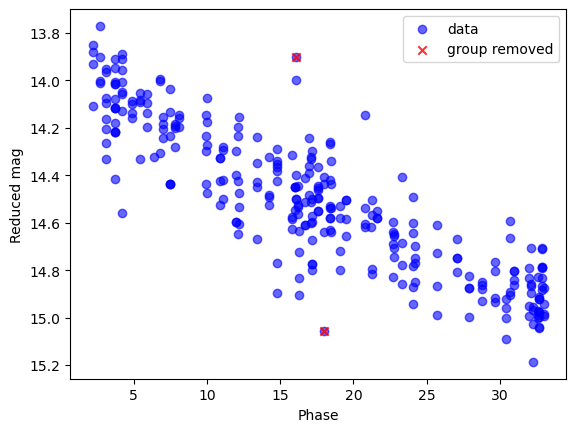

No RA or Dec provided but epoch and target found.
Querying ephemerides via IMCCE Miriade..


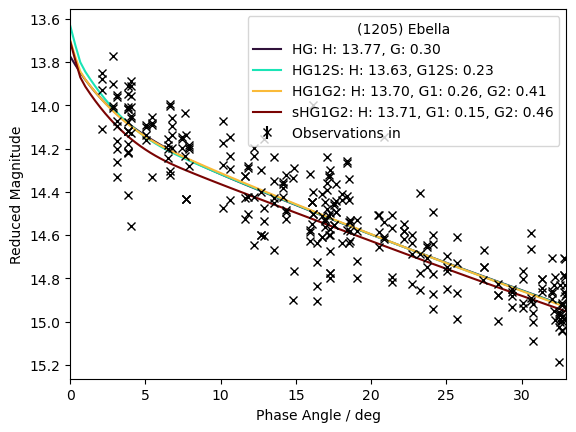

[[ 0.10962107  0.11778354 -0.00775945]
 [ 0.11778354  0.14082731 -0.01704184]
 [-0.00775945 -0.01704184  0.00598955]]
Average displacement HG1G2:  0.04365059462646759


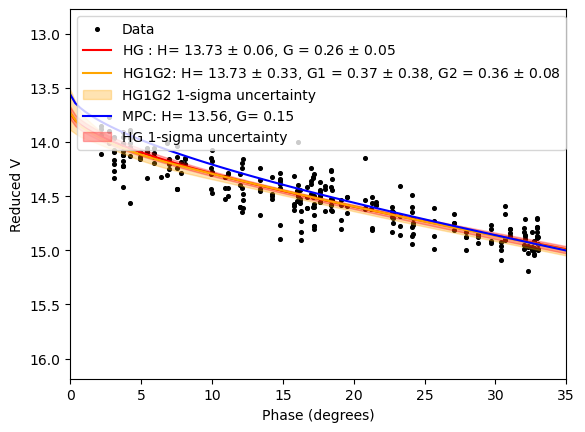

Average displacement HG:  0.04649365375801029


In [28]:
path = r"C:\Users\nagai\Downloads\\"
excel_file = '1205-excelBF.xlsx'

main(path, excel_file, "1205", 13.56, outlier_removing= False, HG1G2=True, interactive = False, sheet_name = "T08o")

# Conclusions

- The MPC is always a notch higher than our fit, therefore the conversion from R to V band seems to be off. More data is needed to accurately do the shift
- Small phase angle observations are needed in order to use HG1G2 method to obtain the most accurate H
- A different value for the HG from phunk and my method, because I include the mag_errors. It is also possible in phunk, but I got some issues with the package there